**從雲端連結下載數據**

In [ ]:
import gdown
url = 'https://drive.google.com/u/1/uc?id=1loBr8ZA8V-B0g8_b2EoLccF2qdaaMqzz&export=download'
output = "Microglia_XAI.zip"
gdown.download(url, output)

Downloading...
From: https://drive.google.com/u/1/uc?id=1loBr8ZA8V-B0g8_b2EoLccF2qdaaMqzz&export=download
To: /content/Microglia_XAI.zip
100%|██████████| 5.28M/5.28M [00:00<00:00, 82.1MB/s]


'Microglia_XAI.zip'

解壓縮下載資料

In [ ]:
import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

file_path = "Microglia_XAI.zip"
zip_list(file_path)

建立Data_loader用來讀取資料

In [ ]:
from torch.utils.data import Dataset
import cv2

#create dataloader
class Data_Loader(Dataset):
    def __init__(self, data_list, transforms, train=True):
        super(Data_Loader, self).__init__()
        self.data_list = data_list
        self.train = train
        self.transforms = transforms  #影像增強

    def __len__(self):
        return len(self.data_list)    #讀取所有資料書量

    def __getitem__(self, item):
        img_path, lab = self.data_list[item].split(' ')
        image = cv2.imread(img_path)#.copy()
        image = self.transforms(image)

        return (image,int(lab))

In [ ]:
建立訓練流程

In [ ]:
import torch
from tqdm import tqdm_notebook
import os


class trainer():
    def __init__(self,model,optimizer,loss_function,epoch,resume,trainloader,testloader,device):
        super(trainer, self).__init__()
        self.model = model          #模型
        self.optimizer = optimizer      #優化器
        self.loss_function = loss_function  #損失函數
        self.epoch = epoch          #訓練次數
        self.resume = resume         #決定是否讀取預訓練資料
        self.trainloader = trainloader    #訓練資料
        self.testloader = testloader     #測試資料
        self.device = device         #CPU or CUDA
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) #震盪learning rate(增加準確度)
        self.best_acc = -1 
        

    def trainer(self): #整體訓練架構
        for ep in range(self.epoch):
            self.train_epoch(ep)
            self.test_epoch(ep)
            self.scheduler.step()
        return self.model

    def train_epoch(self,epoch):#訓練流程
        loss_total = 0.0          #計算頻均loss
        self.model.train()          #設定為訓練模式
        train_loader = tqdm_notebook(self.trainloader)   #進度條可視化
        correct = torch.zeros(1).squeeze().cuda()     #累計正確資料
        total = torch.zeros(1).squeeze().cuda()     #累計每批batch資料
        for i, (img, lab) in enumerate(train_loader):   #開始訓練
            img = img.to(self.device).float()      #設定圖像資料型態
            lab = lab.to(self.device).long()      #設定標籤資料型態


            self.optimizer.zero_grad()    #優化
            out = self.model(img)     #預測

            loss = self.loss_function(out, lab) #計算loss

            loss.backward()   #反向傳播
            self.optimizer.step()
            train_loader.set_postfix(loss=float(loss)) #設定進度條時刻顯示loss數值
            train_loader.set_description(f"Now epoch {epoch}")  #設定進度條標頭

            loss_total += loss.item()   #計算loss總數
            pred = torch.argmax(out,1)   #尋找預測結果
            correct += (pred == lab).sum().float()  #計算正確數量
            total += len(lab) #計算batch大小

        print('totle_loss:',loss_total/len(train_loader))   #打印頻均loss
        print('Accuracy: %f' %((correct/total).cpu().detach().data.numpy())) #打印準確度


    def test_epoch(self,epoch):#測試流程
        self.model.eval()   #設定模型為測試模式
        loss_total = 0.0
        correct = torch.zeros(1).squeeze().cuda()
        total = torch.zeros(1).squeeze().cuda()
        test_loader = self.testloader
        print('\nvalidation......')
        with torch.no_grad():
            for batch_idx, (img, lab) in enumerate(self.testloader): #開始測試
                img = img.to(self.device).float()
                lab = lab.to(self.device).long()

                out = self.model(img)
                loss = self.loss_function(out, lab)

                loss_total += loss.item()
                predicted = out.max(1)[1]
                total += lab.size(0)
                correct += predicted.eq(lab).sum().item()


        acc = correct / total
        print('totle_loss:',loss_total/len(test_loader))
        print('Accuracy: %f' %((correct/total).cpu().detach().data.numpy()))


        # Save checkpoint.

        if acc > self.best_acc:
            print('Saving..')
            state = {
                'net': self.model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt' + str(float(acc)) + '.pth')
            self.best_acc = acc
            
        state = {
            'net': self.model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')


In [ ]:
lr = 0.01    #學習率
resume = False  #是否使用預訓練資料
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
best_acc = 0  # best test accuracy
epoch = 150   
batch_size = 10 

In [ ]:
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchvision import models

In [ ]:
#資料前處理與資料增強
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#修改以下file可訓練不同類型資料
#file = 'Control.txt'
#file = 'TBI.txt'
file = 'Mix.txt'
with open(file,'r') as f:
    data = f.read().split('\n')


trainset, validation = train_test_split(data, random_state=777, train_size=0.85)  #分類資料為測試資料與訓練資料
trainsets = Data_Loader(trainset,transform_train)
validsets = Data_Loader(validation,transform_test)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(validsets, batch_size=batch_size, shuffle=False, num_workers=0)

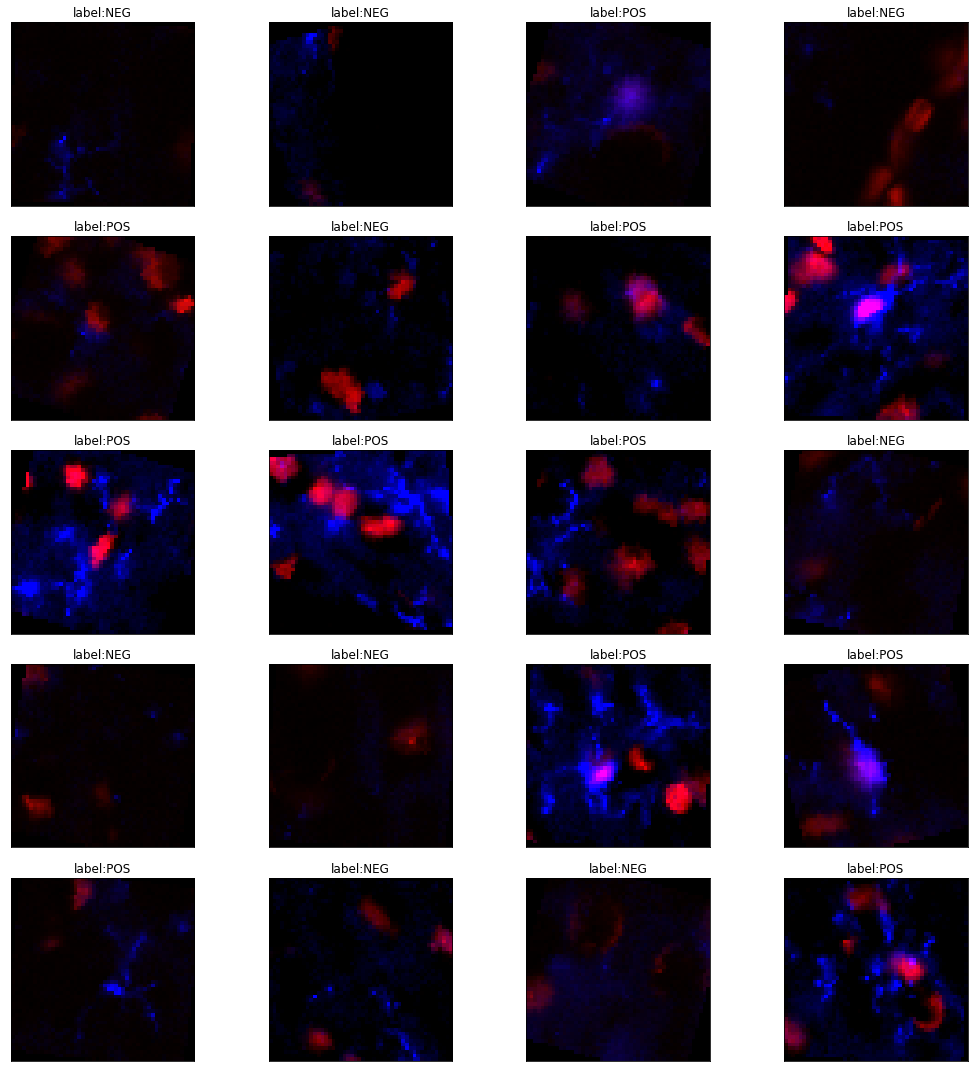

In [ ]:
#顯示圖像
import matplotlib.pyplot as plt
import numpy as np
import cv2

row = 5
col = 4

class_dic = {0:'NEG', 1:'POS'}

fig, ax = plt.subplots(nrows=row, ncols=col, sharex='all', sharey='all', ) # 一张图片有5行5列个子图
fig.set_figheight(15)
fig.set_figwidth(15)
ax = ax.flatten()

for idx,data in enumerate(trainsets):
    if idx == 20:
        break
    img, lab = data[0].permute(1,2,0), data[1]
    img = np.array(img)
    #img = cv2.resize(img,(100,100))
    ax[idx].imshow(img)
    ax[idx].set_title("label:"+ class_dic[lab])
    ax[0].set_xticks([])
    ax[0].set_yticks([])

plt.tight_layout()  # 自动紧凑布局
plt.show()

In [ ]:
#開始訓練
if __name__ == '__main__':  #如果num_worker(多核心處理)需要加上
    model = models.resnet50(num_classes=2).to(device) #定義模型
    if resume:  
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
      checkpoint = torch.load('checkpoint/ckpt.pth')
      model.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
      
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=lr,
        betas=(0.9, 0.999),
    )
    loss_function = nn.CrossEntropyLoss()
    trainer = trainer(
        model=model,
        optimizer=optimizer,
        loss_function=loss_function,
        epoch=epoch,resume=resume,
        trainloader=trainloader,
        testloader=validloader,
        device=device
    )
    model = trainer.trainer()

totle_loss: 0.15539854910679674
Accuracy: 0.941041

validation......
totle_loss: 0.25879988943537074
Accuracy: 0.878788


  0%|          | 0/131 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# def get_pil_transform(): 
#     transf = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomHorizontalFlip(),
#     ])    

#     return transf

def get_preprocess_transform():   #定義資料預處理
    return transform_test

preprocess_transform = get_preprocess_transform()

In [ ]:
import torch.nn.functional as F
#預測影像方法
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
# cor = 0
# for i in validation:
#     img_path, lab = i.split(' ')
#     img = cv2.imread(img_path)

#     test_pred = batch_predict([img.copy()])
#     test_max = int(np.where(test_pred.squeeze()==np.max(test_pred.squeeze()))[0][0])
#     if test_max == int(lab):
#         cor = cor + 1
# print('acc=',cor/len(validation))
#顯示預測結果
img_path, lab = trainset[-16].split(' ')
img = cv2.imread(img_path)

test_pred = batch_predict([img.copy()])
print(test_pred.squeeze())
test_max = int(np.where(test_pred.squeeze()==np.max(test_pred.squeeze()))[0][0])
print(test_max,lab)
print('test_max:',class_dic[test_max],'label:',class_dic[int(lab)])

[0.6721065  0.32789356]
0 0
test_max: NEG label: NEG


In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 4.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=670db12f33019841a93df6038ea17d391ad881a89b8bc9350492827a58fc7166
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image #資料分析
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, #使用解釋器
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from skimage.segmentation import mark_boundaries

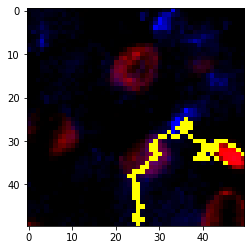

In [ ]:
#顯示遮罩影像
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

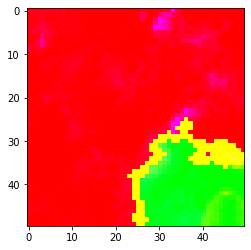

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
